# A General Case

Author(s): Kyle Godbey
Maintainer: Kyle Godbey

To take this particular problem to its natural conclusion, we will be now devising a way to automatically generate our Hamiltonian and ansatz circuits based on what basis dimension we want to calculate.

To do this in the most straightforward manner, I will first implement the Hamiltonian in second quantization before mapping it to a Pauli representation. To help out, I'll be importing some tools from qiskit as well as pennylane, proving that frameworks can indeed work together!

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
import warnings
warnings.filterwarnings('ignore')

We'll also need some helper functions to parse Pauli strings and construct our pennylane Hamiltonian, so I'll just dump them here.

In [5]:
def pauli_token_to_operator(token):
    """
    DO NOT MODIFY anything in this function! It is used to judge your solution.

    Helper function to turn strings into qml operators.

    Args:
        token (str): A Pauli operator input in string form.

    Returns:
        A qml.Operator instance of the Pauli.
    """
    qubit_terms = []

    for term in range(len(token)):
        # Special case of identity
        if token[term] == "I":
            pass
        else:
            #pauli, qubit_idx = term, term
            if token[term] == "X":
                qubit_terms.append(qml.PauliX(int(term)))
            elif token[term] == "Y":
                qubit_terms.append(qml.PauliY(int(term)))
            elif token[term] == "Z":
                qubit_terms.append(qml.PauliZ(int(term)))
            else:
                print("Invalid input.")
    if(qubit_terms==[]):
            qubit_terms.append(qml.Identity(0))
    full_term = qubit_terms[0]
    for term in qubit_terms[1:]:
        full_term = full_term @ term

    return full_term


def parse_hamiltonian_input(input_data):
    """
    DO NOT MODIFY anything in this function! It is used to judge your solution.

    Turns the contents of the input file into a Hamiltonian.

    Args:
        filename(str): Name of the input file that contains the Hamiltonian.

    Returns:
        qml.Hamiltonian object of the Hamiltonian specified in the file.
    """
    # Get the input
    coeffs = []
    pauli_terms = []
    chunks = input_data.split("\n")
    # Go through line by line and build up the Hamiltonian
    for line in chunks:
        #line = line.strip()
        tokens = line.split(" ")
        # Parse coefficients
        sign, value = tokens[0][0], tokens[1]

        coeff = float(value)
        if sign == "-":
            coeff *= -1
        coeffs.append(coeff)

        # Parse Pauli component
        pauli = tokens[3]
        
        pauli_terms.append(pauli_token_to_operator(pauli))

    return qml.Hamiltonian(coeffs, pauli_terms)


Something else that will be very important is a function to compute the matrix elements $\langle n' | (\hat{T} + \hat{V}) | n \rangle$ needed for our Hamiltonian.

In [6]:
def kron(i,j):
    if(i==j):
        return 1
    else:
        return 0

def matrix_element(i,j):
    
    ele = 0.0
    
    ele = ((2.0*i + 1.5)*kron(i,j) - np.sqrt(i*(i+0.5))*kron(i,j+1) \
    - np.sqrt((i+1)*(i+1.5))*kron(i,j-1)) * 3.5
    
    ele += -5.68658111 * kron(i,0) * kron(i,j)
    
    
    return ele

Lastly, we'll make a function that returns a pennylane compatible Hamiltonian given a requested basis dimension, N.

In [8]:
def deuteron_ham(N,mapper=JordanWignerMapper):
    # Start out by zeroing what will be our fermionic operator
    op = 0
    for i in range(N):
        for j in range(N):
            # Construct the terms of the Hamiltonian in terms of creation/annihilation operators 
            op += matrix_element(i,j) * \
            FermionicOp([([("+", i),("-", j)], 1.0)])

    hamstr = "+ "+str(mapper().map(second_q_op=op))

    hamiltonian = parse_hamiltonian_input(hamstr)

    return hamiltonian 


Let's take a look at our new Hamiltonian generator in the next code block. We'll start by setting the basis dimension to 3 so we can compare our two Hamiltonians: handcrafted and computer generated.

In [12]:
dim = 3

# Building our Hamiltonian for the N=3 case, as before

coeffs = [15.531709 ,-2.1433, -2.1433, 0.21829, -6.125, -9.625, -3.91, -3.91]
obs = [qml.Identity(0),qml.PauliX(0) @ qml.PauliX(1), qml.PauliY(0) @ qml.PauliY(1),qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliX(1) @ qml.PauliX(2),qml.PauliY(1) @ qml.PauliY(2)]

ham = qml.Hamiltonian(coeffs, obs)

# Let's print it out

print("Original Hamiltonian: \n",ham)

# Let's now use our new function!

H = deuteron_ham(dim)

print("Generated Hamiltonian: \n",H)

Original Hamiltonian: 
   (-9.625) [Z2]
+ (-6.125) [Z1]
+ (0.21829) [Z0]
+ (15.531709) [I0]
+ (-3.91) [X1 X2]
+ (-3.91) [Y1 Y2]
+ (-2.1433) [X0 X1]
+ (-2.1433) [Y0 Y1]
Generated Hamiltonian: 
   (-9.625) [Z0]
+ (-6.125) [Z1]
+ (0.21829055499999983) [Z2]
+ (15.531709445) [I0]
+ (-3.913118960624632) [Y0 Y1]
+ (-3.913118960624632) [X0 X1]
+ (-2.1433035249352805) [Y1 Y2]
+ (-2.1433035249352805) [X1 X2]


We still need to define our device and circuit, so we'll let them be general as well.

In [13]:
dim = 3

# In this case we now need 3 qubits

dev = qml.device("default.qubit", wires=dim)

# Defining our ansatz circuit for the N=3 case

def circuit(params,wires):
    t0 = params[0]
    t1 = params[1]
    qml.PauliX(wires=0)
    qml.RY(t1, wires=1)
    qml.RY(t0, wires=2)
    qml.CNOT(wires=[2,0])
    qml.CNOT(wires=[0,1])
    qml.RY(-t1, wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])

# Defining Hamiltonian

H = deuteron_ham(dim)

print("Generated Hamiltonian: \n",H)

cost_fn = qml.ExpvalCost(circuit, H, dev)


Generated Hamiltonian: 
   (-9.625) [Z0]
+ (-6.125) [Z1]
+ (0.21829055499999983) [Z2]
+ (15.531709445) [I0]
+ (-3.913118960624632) [Y0 Y1]
+ (-3.913118960624632) [X0 X1]
+ (-2.1433035249352805) [Y1 Y2]
+ (-2.1433035249352805) [X1 X2]


Amazing! That's an even better looking Hamiltonian!

Now we'll set up what we'll need for the VQE procedure; namely some initial parameters and convergence info. You can select the initial guess randomly, but in this case we'll set it manually for repeatability.

In this case, we also need an additional parameter as mentioned when we set up our circuit.

In [14]:
# Our parameter array, only one lonely element in this case :c

init_params = np.array([2.5,4.5])

# Convergence information and step size

max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

Finally, the VQE block. We're still using the standard gradient descent optimizer since it worked so well before, but soon the time will come to shop around for better options.

In [15]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):

    # Take a step in parameter space and record your energy
    params, prev_energy = opt.step_and_cost(cost_fn, params)

    # This keeps track of our energy for plotting at comparisons
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    # Here we see what the energy of our system is with the new parameters
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} MeV,  Convergence parameter = {"
            ":.8f} MeV".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} MeV".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 2.62754488 MeV,  Convergence parameter = 0.41528526 MeV
Iteration = 20,  Energy = -1.45759287 MeV,  Convergence parameter = 0.07290178 MeV
Iteration = 40,  Energy = -1.98314671 MeV,  Convergence parameter = 0.00676702 MeV
Iteration = 60,  Energy = -2.03668718 MeV,  Convergence parameter = 0.00089606 MeV
Iteration = 80,  Energy = -2.04435261 MeV,  Convergence parameter = 0.00013419 MeV
Iteration = 100,  Energy = -2.04548435 MeV,  Convergence parameter = 0.00001928 MeV
Iteration = 120,  Energy = -2.04564498 MeV,  Convergence parameter = 0.00000269 MeV

Final value of the energy = -2.04566218 MeV
Number of iterations =  131


As expected, we get closer to the true value with our expanded basis, though we're not all the way there. We still match our reference value very well, meaning we're on the right track for building out our robust nuclear VQE framework, so good job team!

Let's plot the convergence next and see if going to 2-D hurt us any.

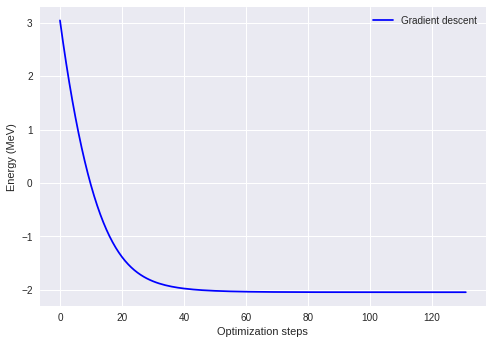

In [16]:
plt.style.use("seaborn")
plt.plot(gd_cost_history, "b", label="Gradient descent")

plt.ylabel("Energy (MeV)")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Since we are now allowed to move in higher dimensions, making a general PES plotter gets a little tricky, but feel free to play around and see if you can think of clever ways to plot how your solution explores the space!

This pretty much concludes our exploration of quantum computing for the deuteron from the point of view of Hamiltonian and state preparation, but there's plenty of other things that can be tried to improve performance! One approach would involce optimizing the ansatz instead of using a generic form, which could be a fun challenge. Another approach is to speed up the VQE algorithm itself, which is exactly what we'll be doing in the next section!